In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields, asdict
import itertools
from itertools import chain, product
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In utils/hub.py: default_cache_path: /raid3/xd/.cache/torch/hub->/nas/xd/.cache/torch/transformers/


In [3]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [4]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils_copy import *
from child_utils_copy import _cxt2str, _item2str, _s
from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils_copy'): from model_utils_copy import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000029
utils ... done 0:00:00.003506
child_utils ... In const.py: Loading tokenizer ... done 0:00:00.199750
done 0:00:00.435493
tasks ... done 0:00:00.009864
model_utils_copy ... done 0:00:05.117312
weight_analysis ... done 0:00:00.000039


In [5]:
torch.set_grad_enabled(False);

In [6]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
#cache_dir='/nas/wab/.cache/huggingface/transformers'
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [7]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['','google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']#wab
gpt_model_names = ['gpt2/cpu','gpt2-medium/cpu','gpt2-xl/cpu','EleutherAI/gpt-j-6B/cpu',]

for model_name in gpt_model_names[0:1]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 0
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 7; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer#, device

gpt2/cpu ... done 0:00:14.132154


In [8]:
models.keys()

dict_keys(['gpt2/cpu'])

In [9]:
model_name = gpt_model_names[0]
# model_name = engines[-1]
model, tokenizer = models[model_name]

In [10]:
blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim

# we = model.transformer.wte.weight.data
# wu = model.lm_head.weight.data

# es = [we]
# for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1]))
# model.es = es
# weBTAs = [es[i].T @ es[i] for i in range(2)]
# model.weBTAs = weBTAs

In [164]:
device = torch.device('cuda:2')
_ = clone_model_to(model, device)

cloning GPT2Block0.ln_1 to cuda:2 ... done 0:00:00.016454
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.003004
cloning GPT2Block1.ln_1 to cuda:2 ... done 0:00:00.000772
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.002742
cloning GPT2Block2.ln_1 to cuda:2 ... done 0:00:00.001378
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.005332
cloning GPT2Block3.ln_1 to cuda:2 ... done 0:00:00.001060
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.004018
cloning GPT2Block4.ln_1 to cuda:2 ... done 0:00:00.000327
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.002065
cloning GPT2Block5.ln_1 to cuda:2 ... done 0:00:00.000590
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.002045
cloning GPT2Block6.ln_1 to cuda:2 ... done 0:00:00.000677
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.002071
cloning GPT2Block7.ln_1 to cuda:2 ... done 0:00:00.000670
cloning GPT2Attention.out_proj to cuda:2 ... done 0:00:00.002047
cloning GPT2Bloc

In [11]:
sys.path.insert(0, '/nas/xd/projects/transformers/notebooks/lzt/Easy-Transformer/easy_transformer')
from ioi_dataset import (
    IOIDataset,
)
N = 50
tokenizer.pad_token = tokenizer.eos_token
ioi_dataset = IOIDataset(
    prompt_type="mixed",
    N=N,
    tokenizer=tokenizer,
    prepend_bos=False,
) 

/nas/xd/projects/transformers/notebooks/lzt/Easy-Transformer/easy_transformer/ioi_dataset.py:770: UserWarning: Some groups have less than 5 prompts, they have lengths [4, 2, 4, 4, 4, 2, 2, 3, 1, 1]
  f"Some groups have less than 5 prompts, they have lengths {small_groups}"


In [12]:
r1 = None
result = {}

Then, Shannon and Benjamin were thinking about going to the office. Benjamin wanted to give a kiss to Shannon

In generate_and_predict_batch: predict ... done 0:00:00.427726


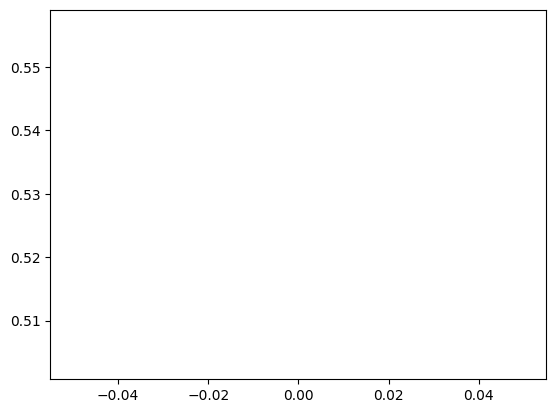

In [13]:
r1, all_examples = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=10,ioi_dataset = ioi_dataset,
                                        trim=False, result=r1, verbose=False)

*ĠShannon 0.776 {'ĠShannon': 0.776, 'Ġher': 0.038, 'Ġthe': 0.036} 	 Then, Shannon and Benjamin were thinking about going to the office. Benjamin wanted to give a kiss to Shannon *ĠShannon:-70.653 ĠBenjamin:-76.014
0.2532395124435425 1.0


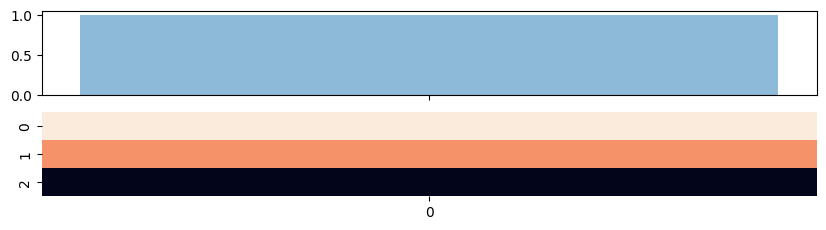

*ĠJames 0.401 {'ĠJames': 0.401, 'Ġthem': 0.111, 'Ġthe': 0.107} 	 Then, James and Katie were working at the hospital. Katie decided to give a drink to James *ĠJames:-92.930 ĠKatie:-98.026
0.9126467704772949 1.0


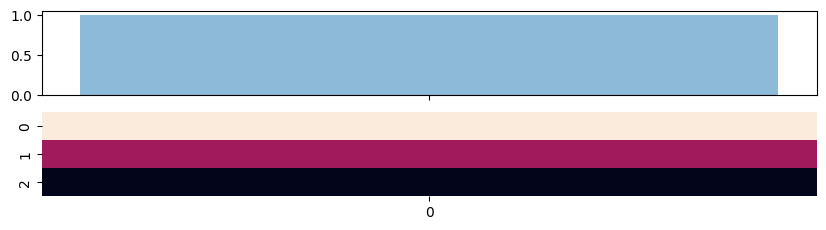

*ĠAndrew 0.5 {'ĠAndrew': 0.5, 'Ġthe': 0.07, 'ĠWilliam': 0.043} 	 After Andrew and William went to the hospital, William gave a computer to Andrew *ĠAndrew:-81.681 ĠWilliam:-84.140
0.6934792399406433 1.0


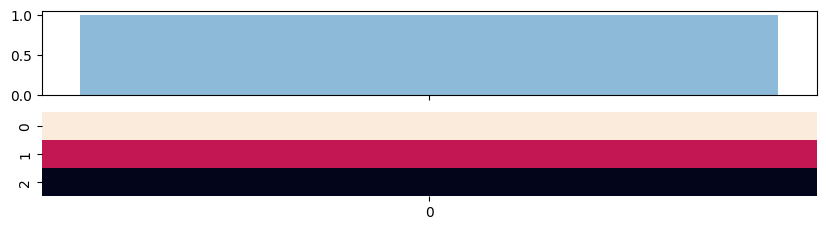

*ĠKenneth 0.281 {'ĠKenneth': 0.281, 'Ġhim': 0.122, 'Ġthem': 0.108} 	 When Brian and Kenneth got a bone at the store, Brian decided to give it to Kenneth *ĠKenneth:-86.662 ĠBrian:-89.874
1.2709919214248657 1.0


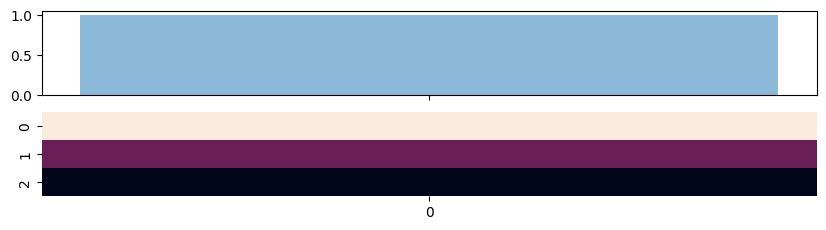

*ĠSean 0.602 {'ĠSean': 0.602, 'ĠHeather': 0.102, 'Ġthe': 0.065} 	 Then, Heather and Sean went to the school. Heather gave a kiss to Sean *ĠSean:-74.098 ĠHeather:-75.871
0.5075456500053406 1.0


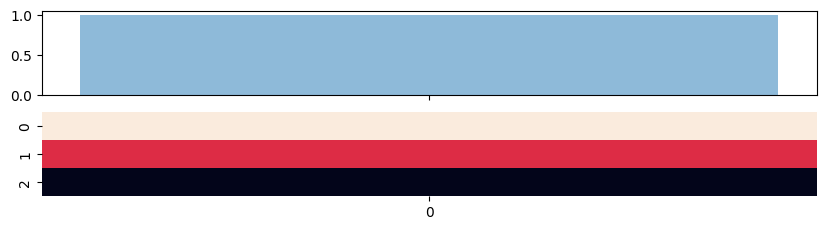

*ĠGregory 0.486 {'ĠGregory': 0.486, 'Ġthe': 0.075, 'ĠRyan': 0.05} 	 After Gregory and Ryan went to the station, Ryan gave a necklace to Gregory *ĠGregory:-79.312 ĠRyan:-81.578
0.7224195599555969 1.0


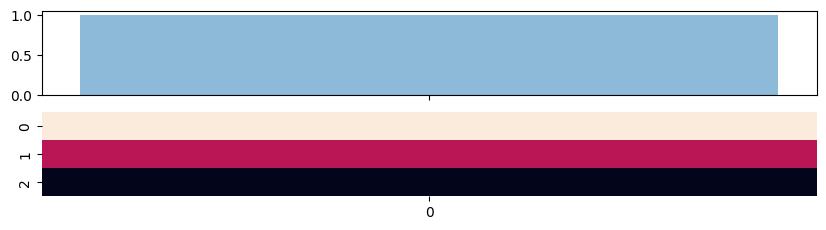

*ĠStephanie 0.316 {'ĠStephanie': 0.316, 'Ġthe': 0.222, 'Ġhis': 0.053} 	 Then, Sean and Stephanie were working at the school. Sean decided to give a bone to Stephanie *ĠStephanie:-59.466 ĠSean:-63.305
1.1511574983596802 1.0


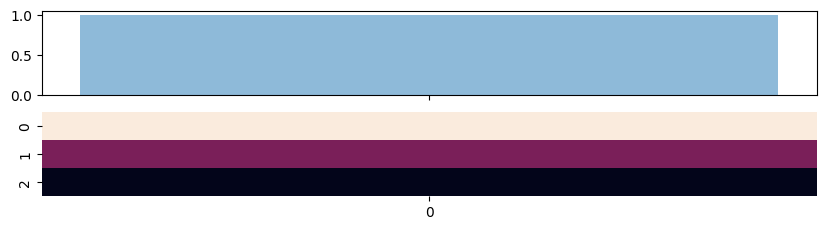

*ĠErica 0.582 {'ĠErica': 0.582, 'Ġthe': 0.052, 'Ġhis': 0.051} 	 Then, John and Erica had a lot of fun at the hospital. John gave a snack to Erica *ĠErica:-83.456 ĠJohn:-86.785
0.5419955849647522 1.0


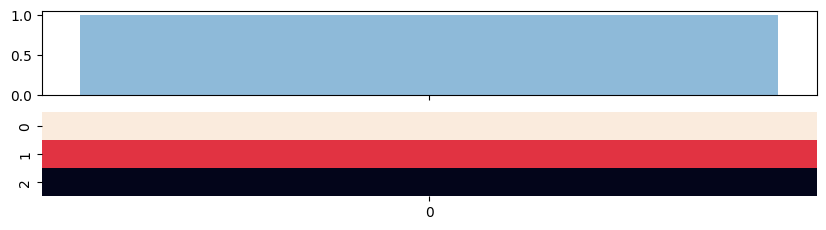

*ĠDustin 0.752 {'ĠDustin': 0.752, 'Ġthe': 0.057, 'Ġher': 0.007} 	 Then, Dustin and Lauren went to the restaurant. Lauren gave a bone to Dustin *ĠDustin:-62.365 ĠLauren:-68.619
0.28457728028297424 1.0


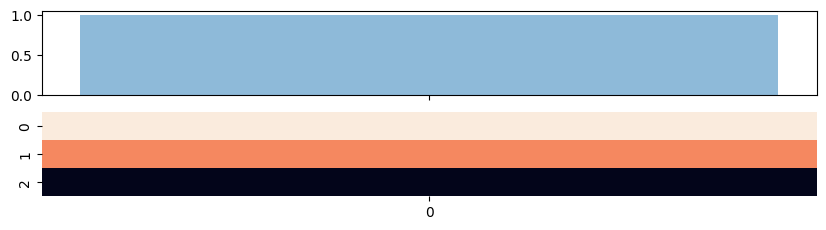

*ĠRichard 0.603 {'ĠRichard': 0.603, 'Ġthe': 0.082, 'ĠJonathan': 0.053} 	 Then, Richard and Jonathan went to the station. Jonathan gave a kiss to Richard *ĠRichard:-72.038 ĠJonathan:-74.478
0.5059224367141724 1.0


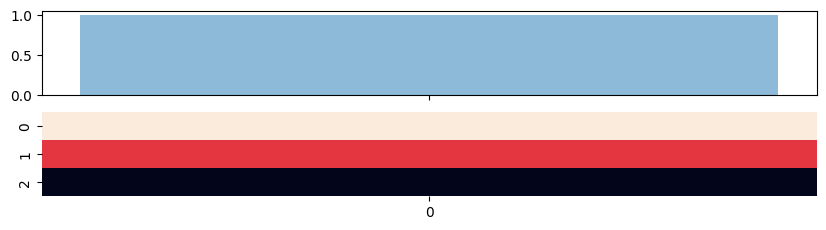

(0.6843975454568862, 1.0)

In [14]:
show_predictions_by_data_tuples(model, tokenizer, r1.data_tuples, k_shot=0)

In [16]:
device = torch.device('cpu')

In [17]:
if True or r1.root is None: r1.root = add_node(None, layer=L, label_type='labels')
r1.root = attribute_tree_on(r1.data_tuples, model, r1.root, 1, topk=10, k_shot=0, mix=True, device=device, verbose=True)

attribute_tree ... In attribute_tree: attribute_step , topk=10 ... done 0:00:01.017121
In attribute_tree: attribute_step stage2  ... done 0:00:00.818496
In _add_node: add @0 9-9 100 B->A0 100/74 attn/ans0s
In _add_node: add @1 10-0 45 B->A0 98/50 attn/ans0s
In _add_node: add @2 9-6 38 B->A0 100/60 attn/ans0s
In _add_node: add @3 10-10 31 B->A0 98/45 attn/ans0s
In _add_node: add @154 11-10 -40 B->A0/72/0 attn/ans0s
In _add_node: add @155 10-7 -59 B->A0/68/0 attn/ans0s
In _add_node: add @[0,1,2,3,4,6,8] 9-9,10-0,9-6,10-10,10-1 19,11-9 10,9-0 7 B->A0 61
In _add_node: add @[5,7] 8-10 10,7-9 8 B->s2 9
In _add_node: add @[9] 11-3 6 unk 0
In _add_node: add 9-9,10-0,9-6,10-10 B->A0 attn/ans0s
In _add_node: add 11-10,10-7 B->A0 attn/ans0s
In attribute_tree: attribute_step 9-9,10-0,9-6,10-10 B->A0 attn/ans0s, topk=8 ... done 0:00:00.314316
In attribute_tree: attribute_step stage2 9-9,10-0,9-6,10-10 B->A0 attn/ans0s ... done 0:00:00.224575
In _add_node: add @0 8-6 100 B->s2 91/65
In _add_node: ad

In [18]:
print_tree(r1.root)

 ┌@[0,1,2,3,4,6,8] 9-9,10-0,9-6,10-10,10-1 19,11-9 10,9-0 7 B->A0 61
 ├@[5,7] 8-10 10,7-9 8 B->s2 9
 ├@[9] 11-3 6 unk 0
 ├@0 9-9 100 B->A0 100/74 attn/ans0s
 ├@1 10-0 45 B->A0 98/50 attn/ans0s
 ├@2 9-6 38 B->A0 100/60 attn/ans0s
 ├@3 10-10 31 B->A0 98/45 attn/ans0s
 ├@154 11-10 -40 B->A0/72/0 attn/ans0s
 ├@155 10-7 -59 B->A0/68/0 attn/ans0s
 ┤
 │                                   ┌@:8 8-6,8-10,7-9,7-3,8-3 15,6-1 10,9-7 7,9-3 5 unk 0
 │                                   ├@0 8-6 100 B->s2 91/65
 │                                   ├@1 8-10 74 B->s2 77/33
 │                                   ├@2 7-9 67 B->s2 93/51
 │                                   ├@3 7-3 35 B->s2 47/16
 ├9-9,10-0,9-6,10-10 B->A0 attn/ans0s┤
 │                                   │                      ┌@[3,4,5,6] 5-12,6-0,0-12,5-9 s2->s2 30
 │                                   │                      ├@:2 5-5 100,6-9 32 s2->s1+ 15
 │                                   │                      ├@[2] 3-0 32 s2->s1 11
 │      

In [37]:
node = r1.root; node.name

''

9-9
scaled_logprobs = tensor([-9.1898e-01, -2.6187e-04, -0.0000e+00, -0.0000e+00])
*ĠShannon 1.0 {'ĠShannon': 1.0, 'ĠBenjamin': 0.0, '"': 0.0, '$': 0.0} 	 Then, Shannon and Benjamin were thinking about going to the office. Benjamin wanted to give a kiss to Shannon *ĠShannon:37.668 ĠBenjamin:12.105
0.0 1.0


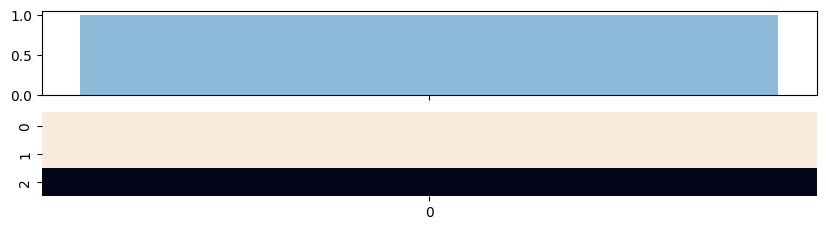

ap_scores = tensor([0.6348]) tensor(0.6348)


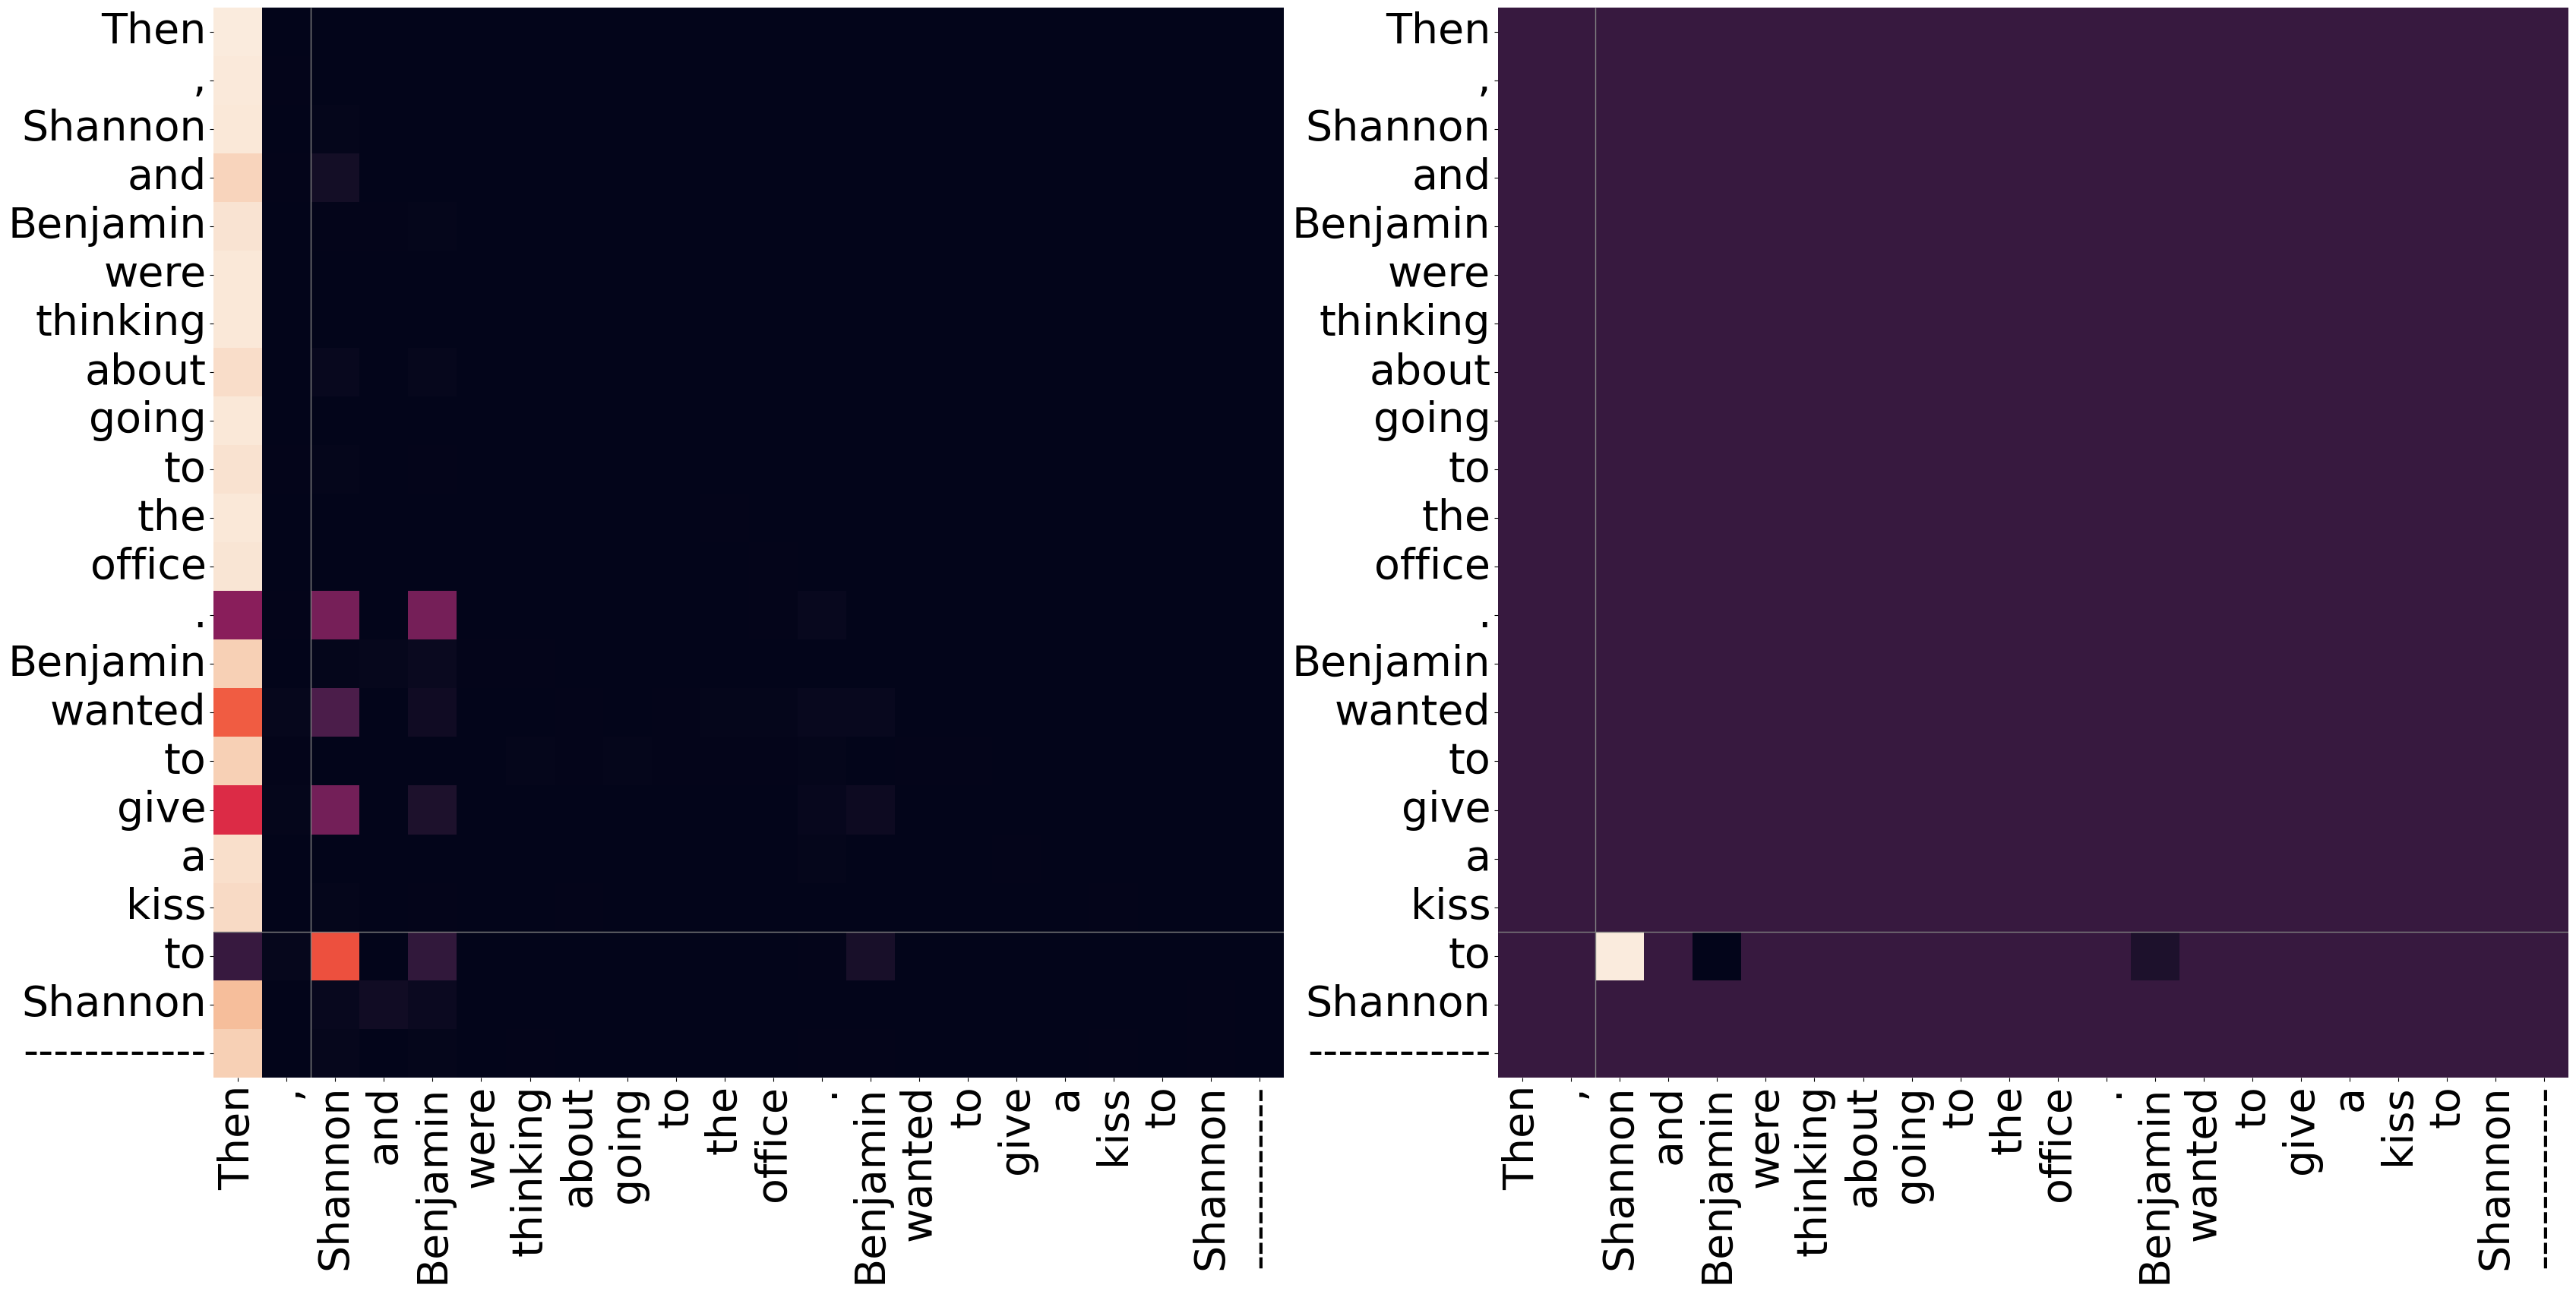

reduced_ap_scores = tensor([0.6348]) tensor(0.6348)


In [38]:
plot_attn_attrs(r1.data_tuples[:1], model, tokenizer, node, topi=[0], attn_patterns=['B->A0'], k_shot=0)  # name-mover 9-9

In [39]:
node = r1.root.children[-2]; node.name

'9-9,10-0,9-6,10-10 B->A0 attn/ans0s'

8-6 -> 9-9,10-0,9-6,10-10 B->A0 attn/ans0s
scaled_logprobs = tensor([0.0471, 0.3773, 0.6308, 0.8551])
resulting ap_scores = tensor([1.]) tensor(1.)
ap_scores = tensor([0.6145]) tensor(0.6145)


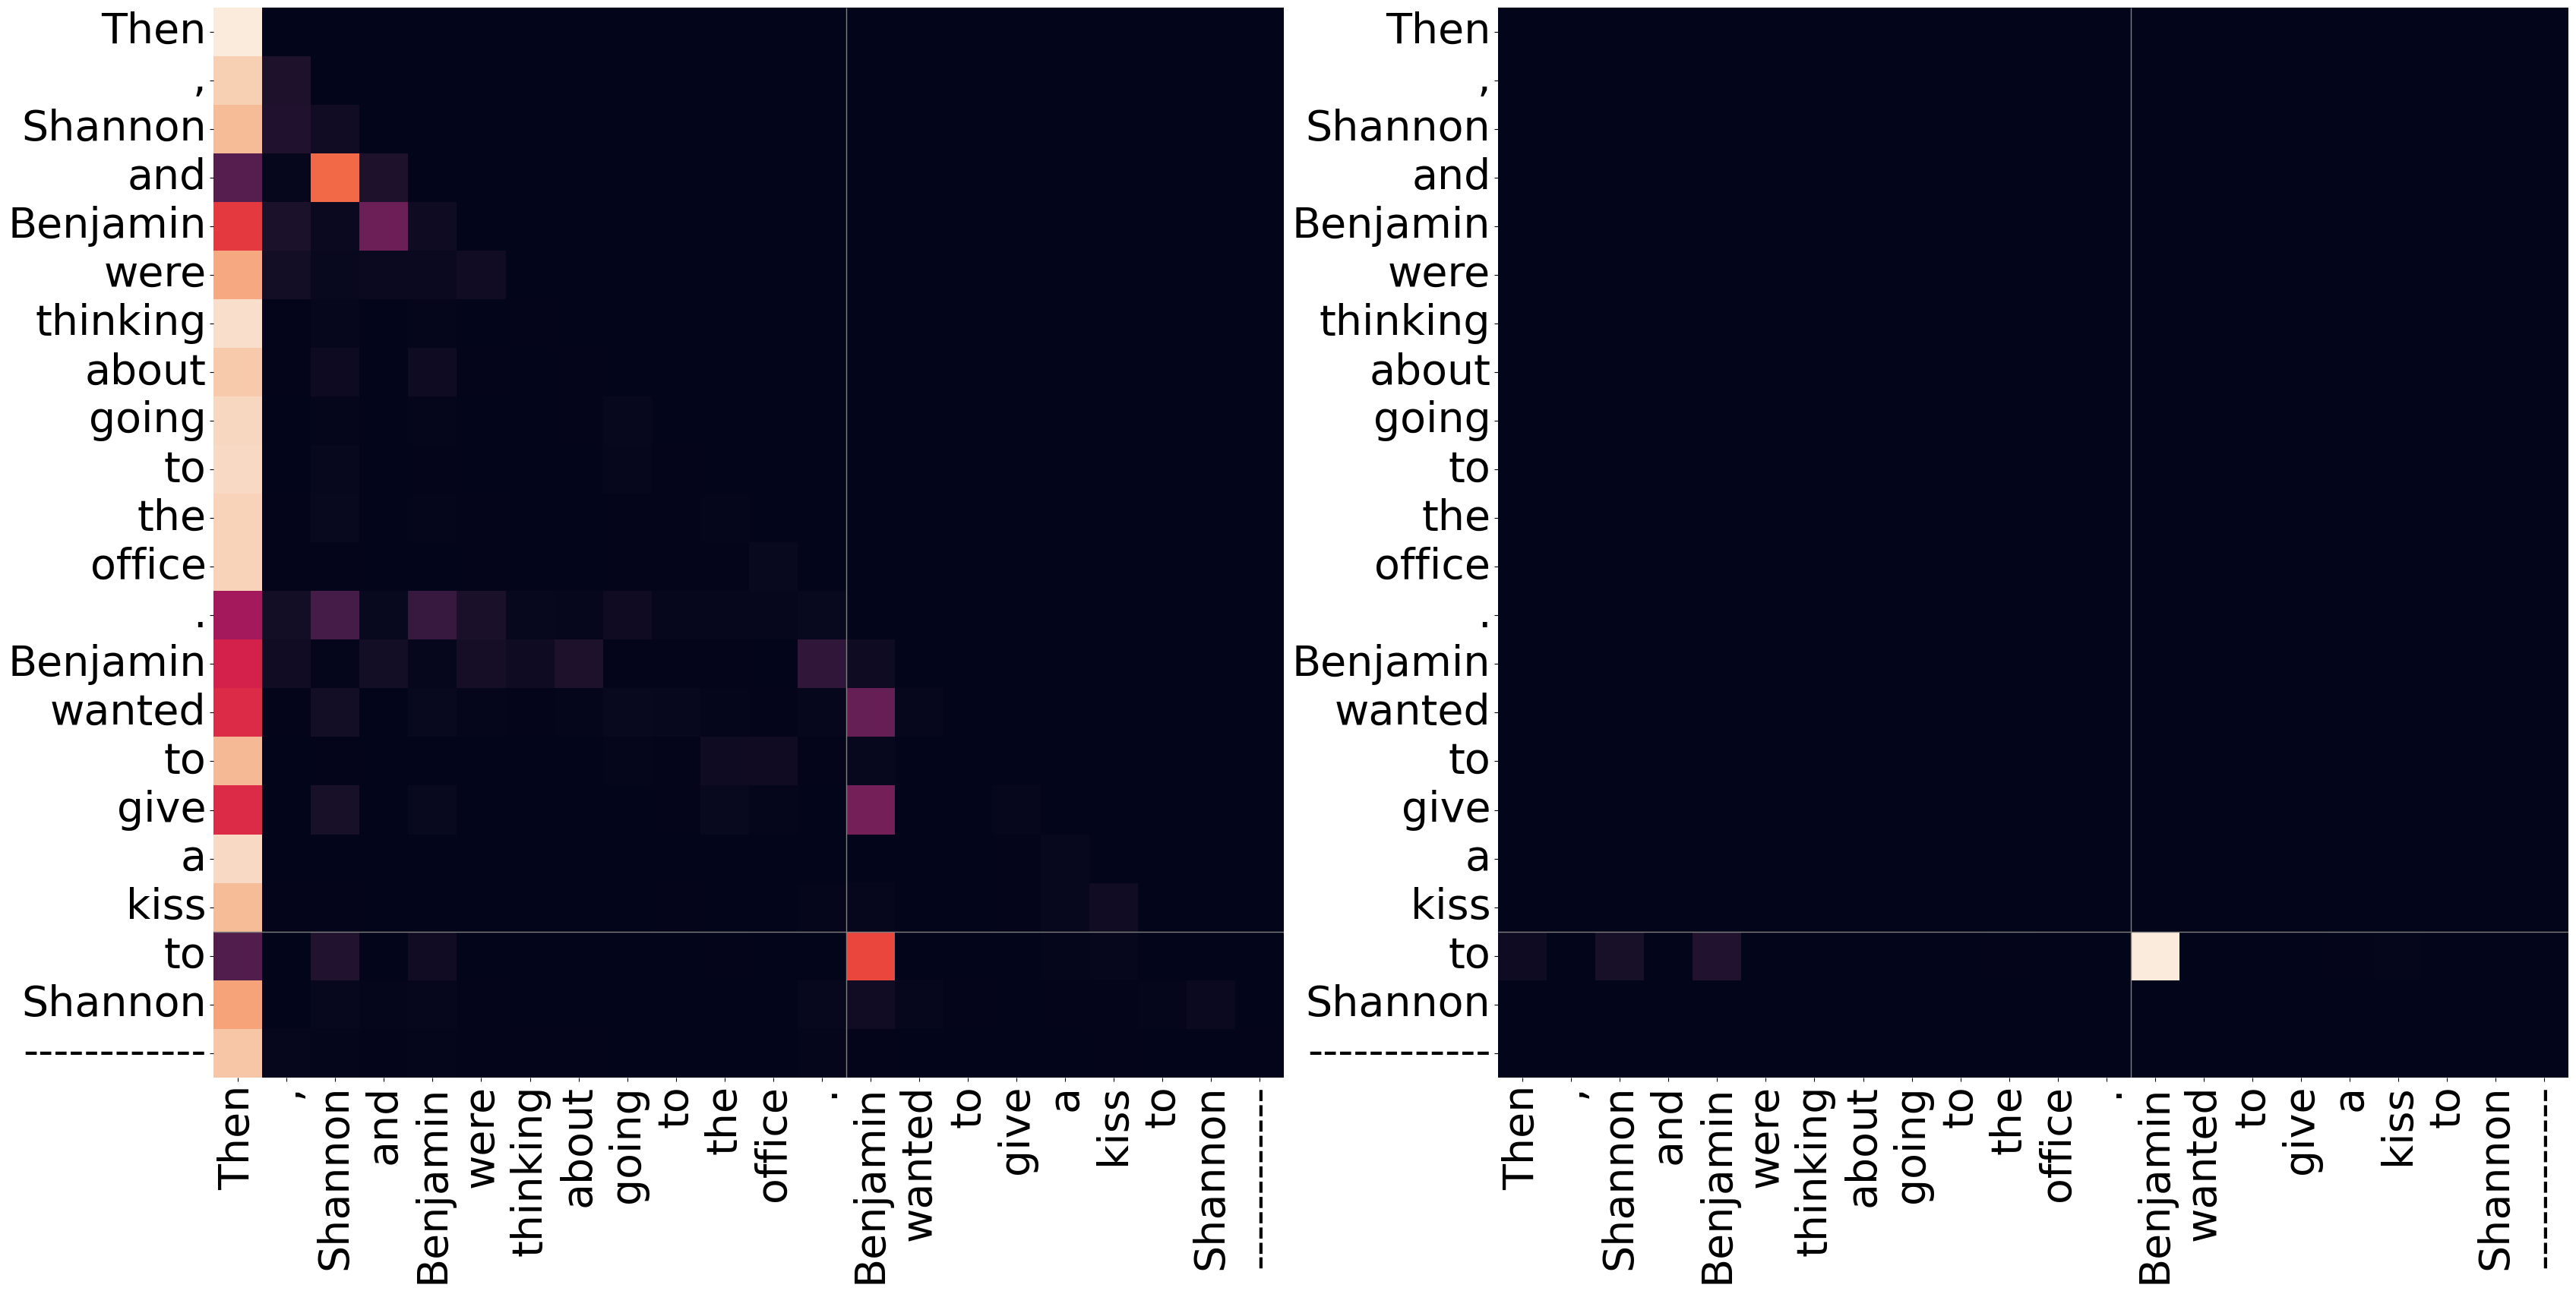

reduced_ap_scores = tensor([0.6145]) tensor(0.6145)


In [40]:
plot_attn_attrs(r1.data_tuples[:1], model, tokenizer, node, topi=[0], attn_patterns=['B->s2'], k_shot=0) # inhibition 8-6

In [41]:
node = r1.root.children[-2].children[-1]; node.name

'8-6,8-10,7-9,7-3 B->s2'

5-5 -> 8-6,8-10,7-9,7-3 B->s2 -> 9-9,10-0,9-6,10-10 B->A0 attn/ans0s
scaled_logprobs = tensor([0.6295, 1.2695, 1.8755, 2.4794])
resulting ap_scores = tensor([1.]) tensor(1.)
ap_scores = tensor([0.8377]) tensor(0.8377)


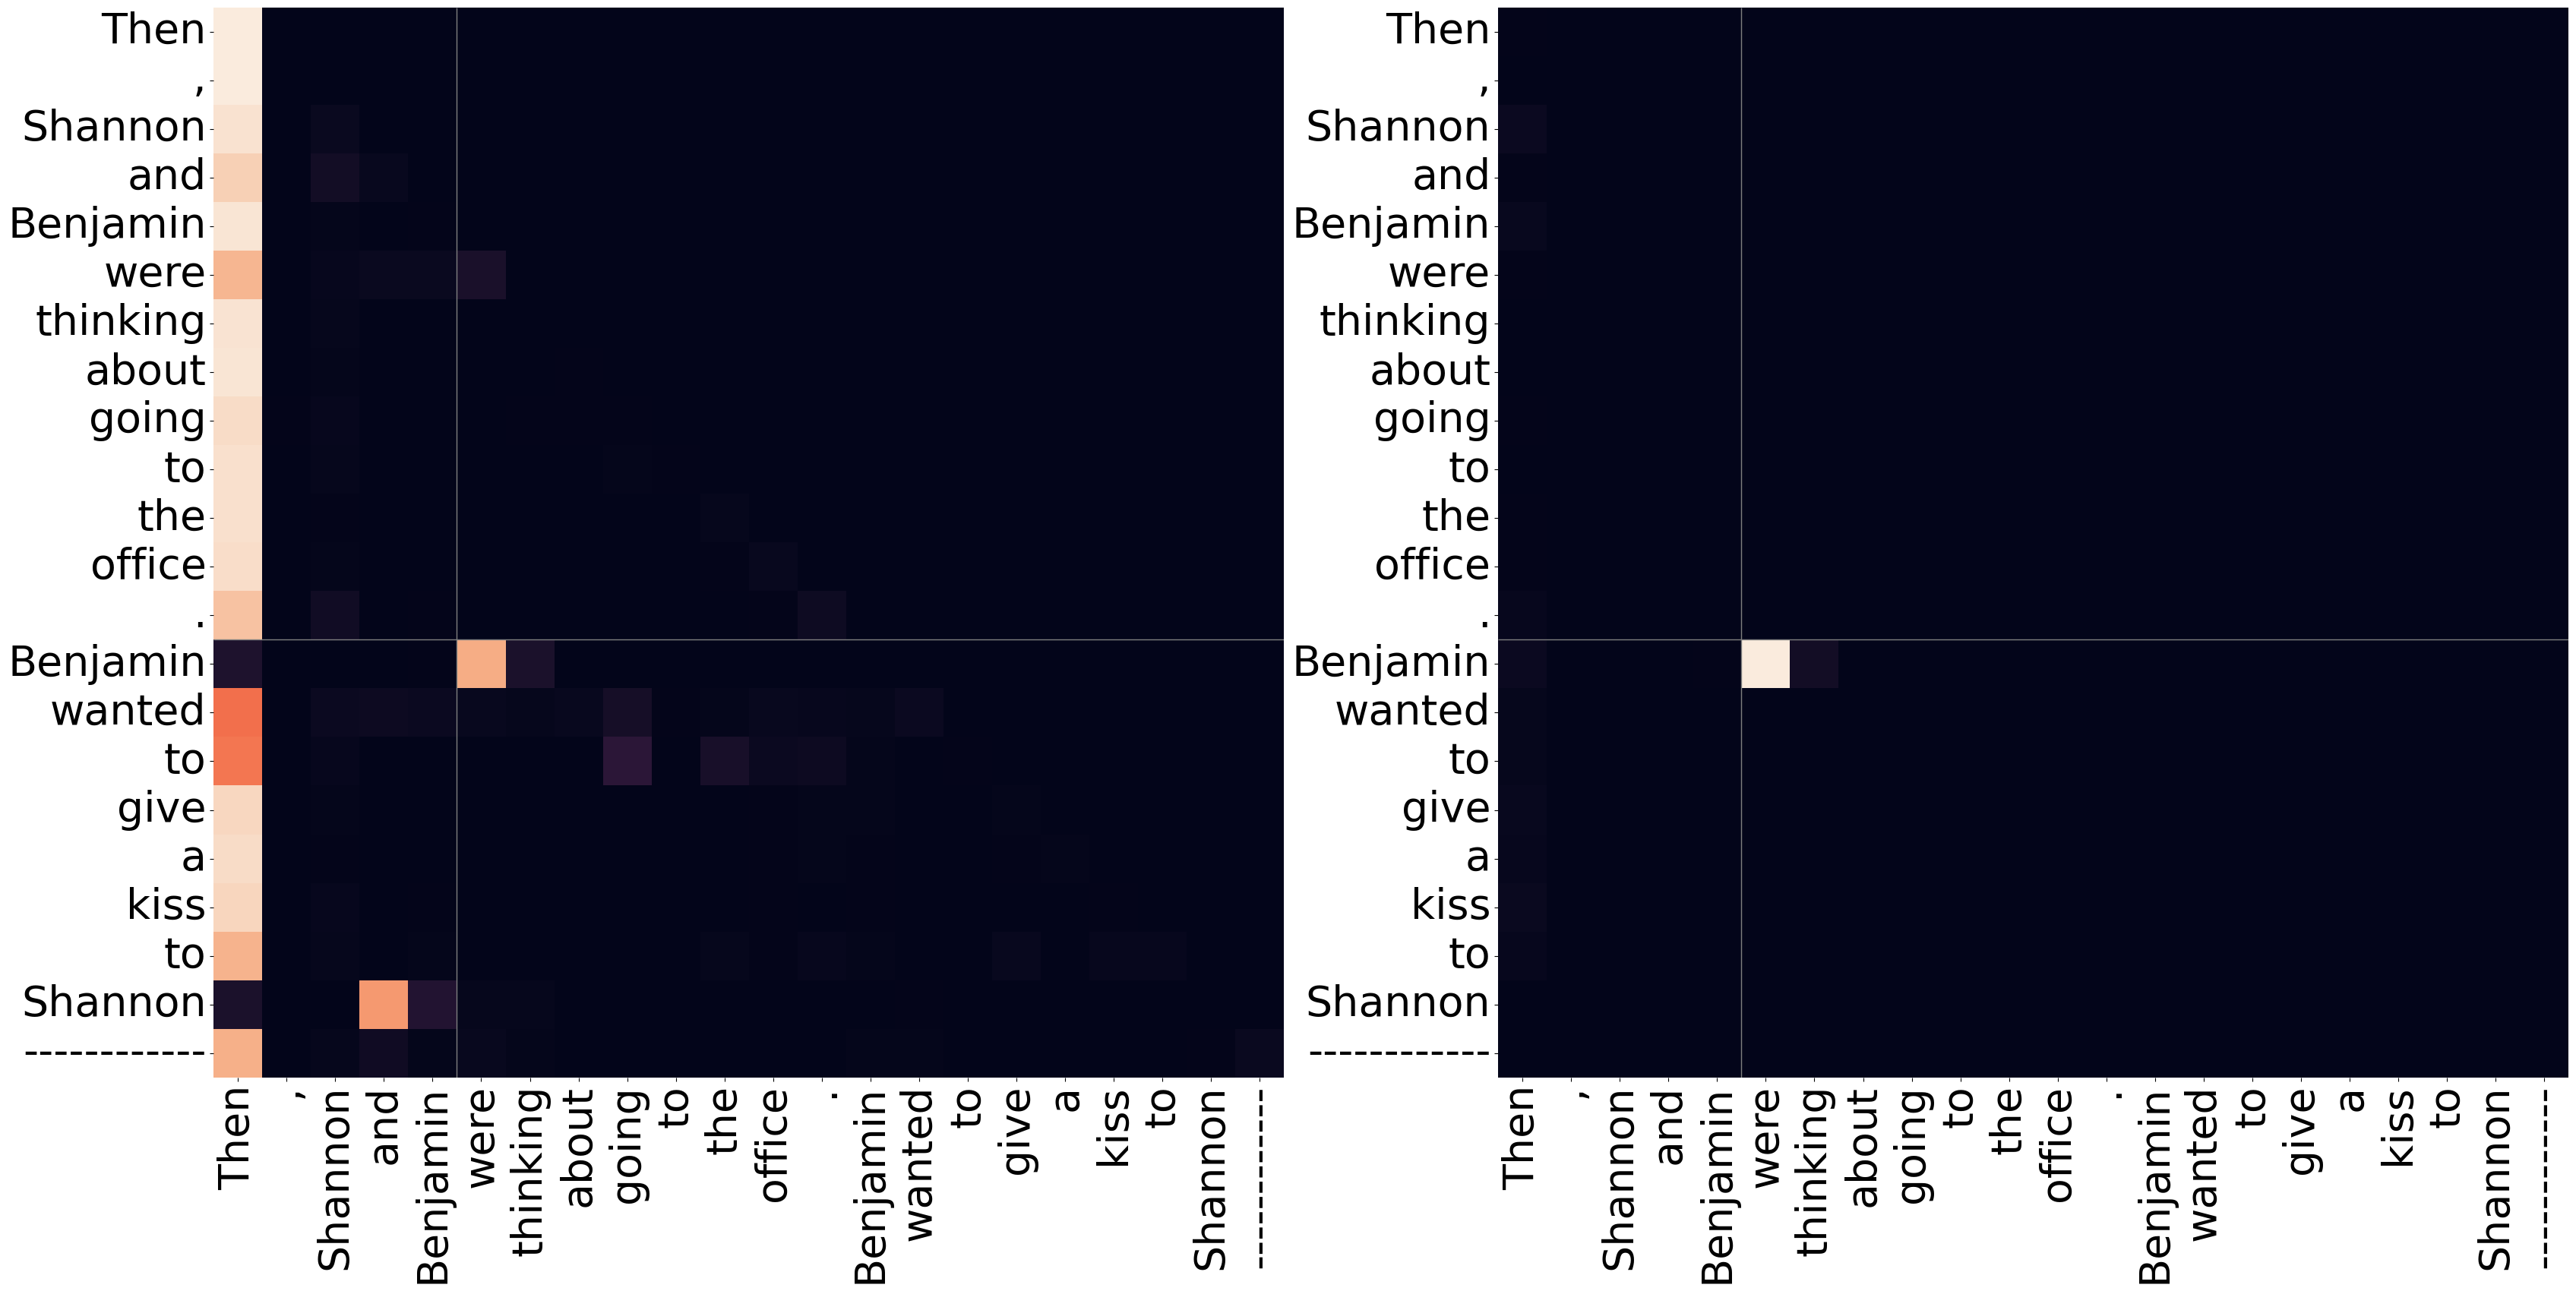

reduced_ap_scores = tensor([0.8377]) tensor(0.8377)


In [42]:
plot_attn_attrs(r1.data_tuples[:1], model, tokenizer, node, topi=[0], attn_patterns=['s2->s1+'], k_shot=0) # induction head 5-5